## bitmapで与えられたMaskデータをPolygonに変換できないか試してみる

In [25]:
import geopandas as gpd
from geopandas import GeoSeries
import sunpy.map

Observatory,SDO
Instrument,HMI SIDE1
Detector,HMI
Measurement,hmi
Wavelength,6173.0
Observation Date,2010-04-30 23:58:22
Exposure Time,0.000000 s
Dimension,[207. 279.] pix
Coordinate System,Unknown
Scale,[0.504348 0.504348] arcsec / pix
Reference Pixel,[3598. 1104.] pix

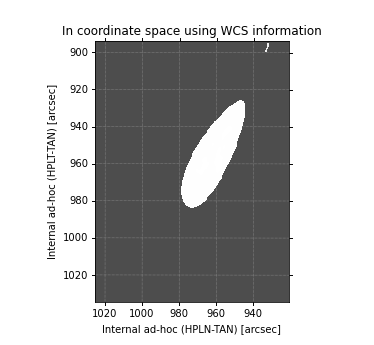
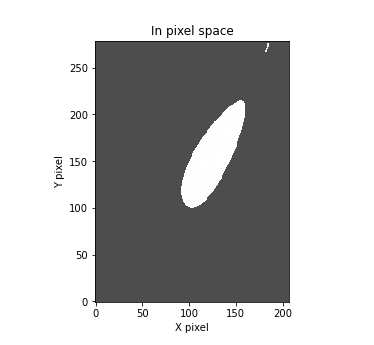
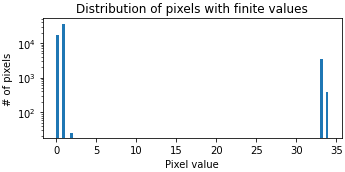

In [26]:
#元データ(Mask)
mask_path = "../samples/sun/Mharp/hmi.Mharp_720s.1.20100501_000000_TAI.bitmap.fits"
mask_map = sunpy.map.Map(mask_path)
mask_map

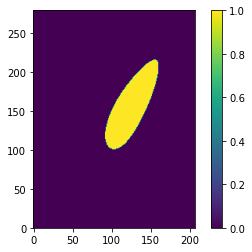

In [27]:
# Geopandasで使用するためにMask部分を１で埋める
import matplotlib.pyplot as plt
import numpy as np
plt.figure(1)
ax = plt.subplot(1,1,1)
ax.set_ylim([0, len(mask_map.data)]); #y軸を反転
binaried_mask_map=np.where((mask_map.data==33)|(mask_map.data==34),1,0)
im = ax.imshow(binaried_mask_map) #climの範囲を変えればダイナミックレンジを変更できる
# im = ax.imshow(np.where(((mask_map.data==34)),1,0))
#カラーバーのプロット
plt.colorbar(im)
# plt.figure(1).suptitle("")#画像の上側にタイトル
# plt.figure(1).savefig("保存するときの名前")#保存
plt.show()

In [28]:
type(binaried_mask_map)

numpy.ndarray

## GDALモジュールを使ってみる
GDALモジュールを使用するとラスターデータ(Bitmap？)からPolygonデータを生成できるみたいなので使えるかどうか試してみる  
[参考:Python3×地理空間データ　GDAL Python API](https://ujicya.jp/blog-mapping/python-gdal-api/)  
[参考:PythonGDAL/OGR document:Raster Layers](http://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html#polygonize-a-raster-band)

### numpy配列からPolygonデータへの加工
gdal_array.OpenArray関数はnumpy配列をデータセットとして変形可能なGDALデータセット形式に変換する。
✖︎その後、Polygonへ

In [29]:
# ✖️
from osgeo import gdal_array,ogr,gdal

raster_map = gdal_array.OpenArray(binaried_mask_map)
raster_map
srcband = raster_map.GetRasterBand(1)
dst_layername = "POLYGONIZED_MASK"
drv = ogr.GetDriverByName("ESRI Shapefile")
dst_ds = drv.CreateDataSource( dst_layername + ".shp" )
dst_layer = dst_ds.CreateLayer(dst_layername, srs = None )

gdal.Polygonize(srcband, None, dst_layer, -1, [], callback=None )

0

うまくいかなかったので別の手を試してみる。  
Rasterioというモジュールが使えるかもしれない  
https://gis.stackexchange.com/questions/187877/how-to-polygonize-raster-to-shapely-polygons  
https://rasterio.readthedocs.io/en/latest/index.html


Polygonをうまく書き出せるか試す
https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.Polygon.html


In [30]:
import rasterio
from rasterio.features import shapes
mask = None

mask_polygon, value = shapes(binaried_mask_map.astype("int16"), mask=mask)
# x = [mask_polygon[0]["coordinates"][0][i][0] for i in range(len(mask_polygon[0]["coordinates"][0]))]
# y = [mask_polygon[0]["coordinates"][0][i][1] for i in range(len(mask_polygon[0]["coordinates"][0]))]
# # type(mask_polygon[0]["coordinates"][0])



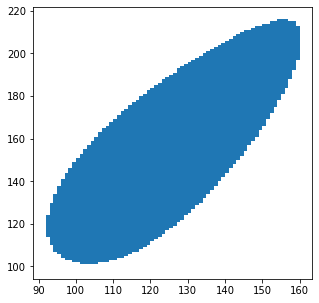

In [31]:
# matplotlib.pyplotをインポート
import matplotlib.pyplot as plt
# matplotlib.patchesをインポート
import matplotlib.patches as pat
# Figureを作成
fig = plt.figure(figsize=(5, 5))
# FigureにAxes(サブプロット)を追加
ax = fig.add_subplot(111)
ax.plot(100,100)
p = pat.Polygon(xy = mask_polygon[0]["coordinates"][0])
ax.add_patch(p)


In [32]:
# MaskPolygonの中身表示
mask_polygon[0]["coordinates"][0]

[(101.0, 101.0),
 (101.0, 102.0),
 (100.0, 102.0),
 (99.0, 102.0),
 (99.0, 103.0),
 (98.0, 103.0),
 (97.0, 103.0),
 (97.0, 104.0),
 (96.0, 104.0),
 (96.0, 106.0),
 (95.0, 106.0),
 (95.0, 107.0),
 (94.0, 107.0),
 (94.0, 110.0),
 (93.0, 110.0),
 (93.0, 114.0),
 (92.0, 114.0),
 (92.0, 124.0),
 (93.0, 124.0),
 (93.0, 130.0),
 (94.0, 130.0),
 (94.0, 134.0),
 (95.0, 134.0),
 (95.0, 138.0),
 (96.0, 138.0),
 (96.0, 141.0),
 (97.0, 141.0),
 (97.0, 144.0),
 (98.0, 144.0),
 (98.0, 146.0),
 (99.0, 146.0),
 (99.0, 149.0),
 (100.0, 149.0),
 (100.0, 151.0),
 (101.0, 151.0),
 (101.0, 153.0),
 (102.0, 153.0),
 (102.0, 155.0),
 (103.0, 155.0),
 (103.0, 157.0),
 (104.0, 157.0),
 (104.0, 159.0),
 (105.0, 159.0),
 (105.0, 161.0),
 (106.0, 161.0),
 (106.0, 163.0),
 (107.0, 163.0),
 (107.0, 165.0),
 (108.0, 165.0),
 (108.0, 166.0),
 (109.0, 166.0),
 (109.0, 168.0),
 (110.0, 168.0),
 (110.0, 169.0),
 (111.0, 169.0),
 (111.0, 171.0),
 (112.0, 171.0),
 (112.0, 173.0),
 (113.0, 173.0),
 (113.0, 174.0),
 (114.0, 

## MaskデータのPolygon化について
上記の方法でBitmapの中身をPolygonに変換することができた。
これを自動化して、データセットと合体するところまで行けば学習に入れると思う

## データセットとの結合について
３次元の光球データと視野方向のデータとのそれぞれでデータセットにOverrayする必要があるのでそれぞれについてどのようにデータを与えるか試す
## 実装のアイディア
1. そもそもの光球データの座標系を確認
2. それぞれのMaskデータはおそらく原点が各ARの左下端になっているので、Maskを置く座標を変換する
3. 同時間帯にあるMaskを全てOverray仕切ったら出力
4. その画像とJSOC提供のデータとの差異を確認
5. 良さそうならデータを全体で作る(COCO Formatに変換)


Observatory,SDO
Instrument,HMI FRONT2
Detector,HMI
Measurement,magnetogram
Wavelength,6173.0
Observation Date,2010-04-30 23:59:07
Exposure Time,0.000000 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.504294 0.504294] arcsec / pix
Reference Pixel,[2042.633423 2044.632202] pix

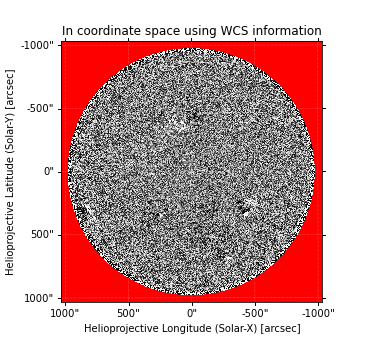
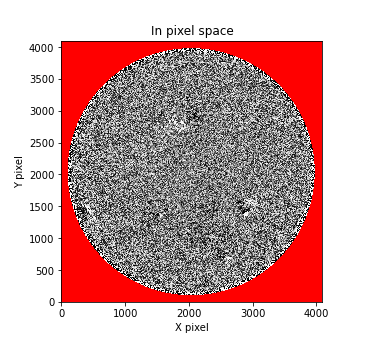
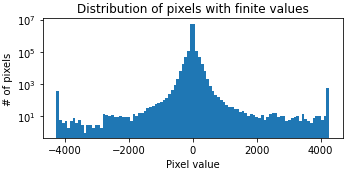

In [33]:
＃# 3Dデータ
hmi_me_path = "../samples/sun/HMI_REGION/hmi.M_45s.20100501_000000_TAI.2.magnetogram.fits"
hmi_me_map = sunpy.map.Map(hmi_me_path)
hmi_me_map

## Maskの座標系の変換
全球データはHelioprojectiveの座標系→太陽の球面状の座標(秒角表記)  
MaskデータはPixel単位での表記なのでそのままはOverrayできない  
→→Mask側を変換してうまくOverrayする方法を考えてみる  
参考になりそうなReference  
https://docs.sunpy.org/en/0.7/code_ref/coordinates.html#module-sunpy.coordinates.transformations  
https://docs.sunpy.org/en/v0.8.2/code_ref/map.html?highlight=sunpy%20map#module-sunpy.map



In [59]:
import astropy.units as u
mask_map.pixel_to_world

<bound method GenericMap.pixel_to_world of <sunpy.map.sources.sdo.HMIMap object at 0x7fa7c2a04198>
SunPy Map
---------
Observatory:		 SDO
Instrument:		 HMI SIDE1
Detector:		 HMI
Measurement:		 hmi
Wavelength:		 6173.0
Observation Date:	 2010-04-30 23:58:22
Exposure Time:		 0.000000 s
Dimension:		 [207. 279.] pix
Coordinate System:	 Unknown
Scale:			 [0.504348 0.504348] arcsec / pix
Reference Pixel:	 [3598. 1104.] pix
Reference Coord:	 [-788.738281  474.840912] arcsec                   
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 0, 0]], dtype=int16)>

In [69]:
# mask_map_world関数は引数としてAstropy.Quantity✖︎2軸分を受け取り、SkyCoordオブジェクトを返す
import sunpy.coordinates
from astropy.wcs.utils import wcs_to_celestial_frame
# mask_map_world = mask_map.pixel_to_world
# mask_map_world(x=100*u.pix,y=100*u.pix)
mask_map.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'Internal ad-hoc (HPLN-TAN)'  'Internal ad-hoc (HPLT-TAN)'  
CRVAL : -788.738281  474.840912  
CRPIX : 3599.0  1105.0  
PC1_1 PC1_2  : -0.9999989633490224  0.0014398961353385468  
PC2_1 PC2_2  : -0.0014398961353385468  -0.9999989633490224  
CDELT : 0.504348  0.504348  
NAXIS : 207  279

In [70]:
from astropy.wcs.utils import wcs_to_celestial_frame
import sunpy.coordinates
import sunpy.map
from sunpy.data.sample import AIA_171_IMAGE
amap = sunpy.map.Map(AIA_171_IMAGE)
wcs_to_celestial_frame(amap.wcs)

<Helioprojective Frame (obstime=2011-06-07T06:33:02.770, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2011-06-07T06:33:02.770): (lon, lat, radius) in (deg, deg, m)
    (-0.00406308, 0.04787238, 1.51846026e+11)>)>

In [84]:
mask_map.observer_coordinate

<SkyCoord (HeliographicStonyhurst: obstime=2010-04-30T23:58:22.200): (lon, lat, radius) in (deg, deg, m)
    (0.06160481, -4.201544, 1.50707441e+11)>